In [30]:
import math
import numpy
from matplotlib import animation
import matplotlib.pyplot as plt
from numba import cuda
%matplotlib notebook

In [35]:
def uniform_gf_quad(fvals, xvals , alpha):

    JLval = [0]     
    JRval = [0]
    
    #assume uniform step size
    h = xvals[1] - xvals[0]
    
    size = len(xvals)    
    
    vj    = alpha*h
    #print(h, alpha)
    dj    = math.exp(-vj) 
    ratio = (1-dj)/vj
    eps = 1e-3
    Q     = -dj + ratio
    #print(vj)
    #if things get small, this blows up 
    if vj>eps:
        P = 1 - ratio
        R = 1-dj-vj/2*(1+dj )
    else:
        print("small stuff")
        P = (h/2-nu**2/6+h**3/24-h**4/120)
        R = -math.exp(-h/2)*(h**3/12+h**5/480+h**7/53760)
  
    quadCoeffs = []  
    for i in range(size):
        if i != 0 and i != (size-1):
            quadCoeffs.append((fvals[i-1] -2*fvals[i] + fvals[i+1])*1/vj**2 )
        elif i == 0:
            quadCoeffs.append((2*fvals[0] -5*fvals[1] +4*fvals[2] - fvals[3])*1/vj**2 )
        else:
            quadCoeffs.append((2*fvals[-1] -5*fvals[-2] +4*fvals[-3] - fvals[-4])*1/vj**2)
        #evaluate the polynomial integral for each J between 0 and N.
    for j in range(size):
        #print (quadCoeffs[j-1],j-1)
        if j != 0:
            #recursive formula to update the value of J
            JLcurr  = P*fvals[j] + Q*fvals[j-1] + quadCoeffs[j]*R
            #print(vj, P, fvals[j] , Q, fvals[j-1] , quadCoeffs[j-1] , R)
            JLval.append( dj*JLval[j-1] + JLcurr )
        if j != size-1:
            JRreverse = P*fvals[-(j+2)]+Q*fvals[ -(j+1) ] + R*quadCoeffs[-(j+1)] 
            #print(JRreverse)
            JRval.append(dj*JRval[j] + JRreverse)
    
    #print(P , Q , R ,quadCoeffs)
    JRval.reverse()
    #print(JRval)
    #print(JRval)
    return [JLval[i] +JRval[i] for i in range(size)]


In [39]:

T = 5
N = 800
a = -2
b = 2

x = numpy.linspace(a,b,N)

CFL = 10
c = 1

dx = x[1]-x[0]
dt = dx/c*CFL

beta = 2
alpha = beta /(CFL*dx)

f = lambda x: numpy.exp(-72*((x-(a+b)/2)/(b-a))**2)
g = lambda x: 144/(b-a)**2*(x-(a+b)/2)*numpy.exp(  -72*( (x-(a+b)/2) / (b-a) )**2)

u0 = [f(xi) for xi in x ]
#u1 = [f(xi) + dt*g(xi) for xi in x]
u1 = [1/2*(f(xi-c*dt)+ f(xi+c*dt) + dt*(g(xi-c*dt)+g(xi+c*dt))) for xi in x]
#u1[0] = (u1[0]+u1[-1])/2
#u1[-1] = u1[0]
t0 = 2*dt

#print(u1)

length=len(x)
d = math.exp(-alpha*dx)
Ga = [dx**n for n in range(length)]
Gb = [dx**(length-1-n) for n in range(length)]
dN = math.exp(-alpha*(b-a))

vL = [(Ga[i]-dN*Gb[i])/(1-dN**2) for i in range(len(Ga))]
vR = [(Gb[i]-dN*Ga[i])/(1-dN**2) for i in range(len(Ga))]

uSoln = [u0,u1]
#print(u1)

while t0<T:
    w = uniform_gf_quad(u1,x,alpha)
    #print(w)
    wsize = len(w)
    #should probably all happen in one or two loops
    w = [w[i] - w[0]*vL[i]-w[-1]*vR[i] for i in range(wsize)]
    w = [u1[i] -.5*w[i] for i in range(wsize)]
    
    u = [2*u1[i] - u0[i]-beta**2*w[i] for i in range(wsize)]
    #print(u)
    u0 = u1
    u1 = u
    #exactSoln = [f(xi - c*t0) for xi in x]
    uSoln.append(u)
    t0+=dt
#print(uSoln[2])

In [40]:
def animate(i):
    line.set_data(x,uSoln[i])
    return line,
def init():
    line.set_data([], [])
    return line,    

<IPython.core.display.Javascript object>


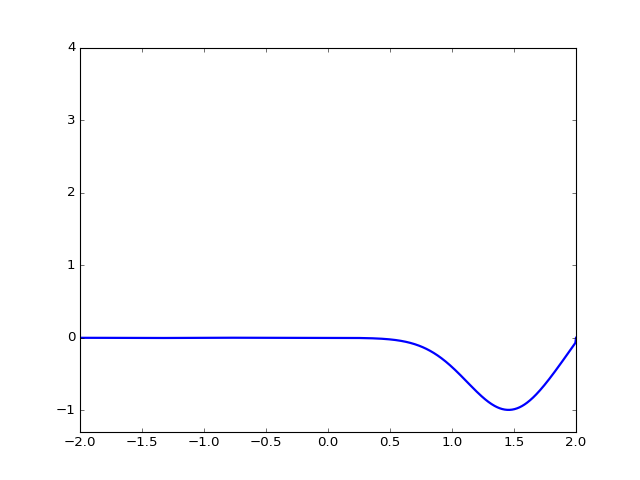

In [41]:
fig   = plt.figure()
ax    = plt.axes(xlim=(-2,2),ylim = (-1.3,4))
line, = ax.plot([],[] , lw=2)
anim = animation.FuncAnimation(fig,animate, frames = len(uSoln),interval=50,blit=True)


In [49]:
T = 5
N = 201
a = -1
b = 1

x = numpy.linspace(a,b,N)

CFL = 1
c = 1

dx = x[1]-x[0]
dt = dx/c*CFL

beta = 2
alpha = beta /(c*dt)

#f = lambda x: math.exp(-72*((x-(a+b)/2)/(b-a))**2)
#g = lambda x: 144/(b-a)**2*(x-(a+b)/2)*math.exp(  -72*( (x-(a+b)/2) / (b-a) )**2)
f = lambda x: 0
g = lambda x: 0
s = lambda x: 10*(math.tanh(20*x-40)**2-math.tanh(20*x-20)**2)


u0 = [f(xi) for xi in x ]
u1 = [f(xi) + dt*g(xi) for xi in x]
#u1 = [1/2*(f(xi-c*dt)+ f(xi+c*dt) + dt*(g(xi-c*dt)+g(xi+c*dt))) for xi in x]
u1[0] = (u1[0]+u1[-1])/2
u1[-1] = u1[0]
t0 = 0

Ga = [math.exp(-alpha*(xi-a)) for xi in x]
Gb = [math.exp(-alpha*(b-xi)) for xi in x]
dN = math.exp(-alpha*(b-a))

sourP = (a+b)/2

vL = [(Ga[i]-dN*Gb[i])/(1-dN**2) for i in range(len(Ga))]
vR = [(Gb[i]-dN*Ga[i])/(1-dN**2) for i in range(len(Ga))]
vs = [math.exp(-alpha*abs(xi-sourP)) for xi in x]

uSoln = [u0,u1]

while t0<T:
    
    w = uniform_gf_quad(u1,x,alpha)
    wsize = len(w)
    w = [w[i] + dt*s(t0)*vs[i] for i in range(wsize) ]
    #should probably all happen in one or two loops
    w = [w[i] + w[0]*vL[i]+w[-1]*vR[i] for i in range(wsize)]
    w = [u1[i] -.5*w[i] for i in range(wsize)]
    u = [2*u1[i] - u0[i]-beta**2*w[i] for i in range(wsize)]
    u0 = u1
    u1 = u
    uSoln.append(u)
    t0+=dt

<IPython.core.display.Javascript object>


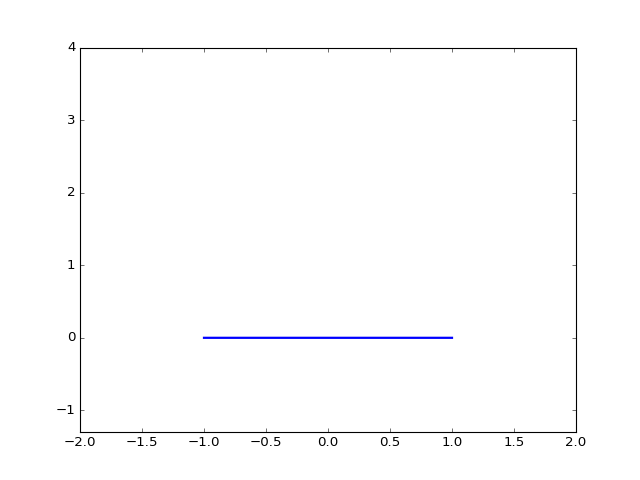

In [33]:
fig   = plt.figure()
ax    = plt.axes(xlim=(-2,2),ylim = (-1.3,4))
line, = ax.plot([],[] , lw=2)
anim = animation.FuncAnimation(fig,animate, frames = len(uSoln),interval=20,blit=True)


In [5]:
x= numpy.linspace(1,5,10)
x.size

10